# Documentação da Classe `DantzigWolfe`
---
## 1. Descrição Geral

Esta classe implementa o algoritmo de **Decomposição de Dantzig-Wolfe** para resolver problemas de programação linear que possuem uma estrutura de blocos angular. A principal vantagem desta abordagem é a capacidade de decompor um problema grande e complexo em um **Problema Mestre** e múltiplos **Subproblemas** (ou problemas de *pricing*) menores e mais fáceis de resolver.

A implementação atual foi projetada para receber o problema já decomposto pelo usuário. Ela orquestra a troca de informações entre o mestre e os subproblemas, gerando colunas (propostas) iterativamente até que a condição de otimalidade seja satisfeita.

## 2. Parâmetros de Entrada

A classe é inicializada com os seguintes parâmetros:

```python
__init__(self, master_b, subproblems, tol=1e-7, max_iter=100)
```

* `master_b` (lista ou `np.array`): Um vetor contendo os termos do lado direito (recursos) das **restrições de acoplamento** (as restrições do Problema Mestre).
* `subproblems` (lista de dicionários): Esta é a entrada principal que define a estrutura de blocos. Cada dicionário na lista representa um subproblema e deve conter as seguintes chaves:
    * `'c'` (`np.array`): O vetor de custos das variáveis pertencentes a este subproblema.
    * `'A_master'` (`np.array`): A matriz dos coeficientes das variáveis deste subproblema nas restrições de acoplamento.
    * `'A_sub'` (`np.array`): A matriz de coeficientes das restrições **próprias** deste subproblema.
    * `'b_sub'` (`np.array`): O vetor do lado direito das restrições próprias deste subproblema.
* `tol` (float, opcional): A tolerância numérica para verificar a condição de otimalidade. O algoritmo para quando o custo reduzido mínimo for maior ou igual a `-tol`. O padrão é `1e-7`.
* `max_iter` (int, opcional): O número máximo de iterações do ciclo mestre-subproblema para evitar loops infinitos. O padrão é `100`.

## 3. Saídas

O método principal da classe é o `solve()`, que retorna uma tupla com dois valores:

```python
final_solution, final_value = dw_solver.solve()
```

* `final_solution` (`np.array`): Um vetor contendo os valores ótimos para **todas as variáveis de decisão originais**, na mesma ordem em que foram definidas nos subproblemas.
* `final_value` (float): O valor ótimo da função objetivo do problema original.

## 4. Detalhes da Implementação para Múltiplos Blocos

A chave para o funcionamento correto do algoritmo com mais de um subproblema (`p > 1`) reside na formulação correta do Problema Mestre e na comunicação entre ele e os subproblemas.

### 4.1. Múltiplas Restrições de Convexidade

Quando existem `p` subproblemas, a solução do problema original é uma combinação convexa das soluções de **cada bloco de forma independente**. Isso é modelado no Problema Mestre através da criação de **`p` restrições de convexidade**, uma para cada subproblema.

A formulação do mestre, portanto, possui:

* `m` restrições de acoplamento (do tipo `<=` ou `>=`).
* `p` restrições de convexidade (do tipo `=`), onde `p` é o número de subproblemas.

A `j`-ésima restrição de convexidade garante que a soma dos pesos (`α`) das propostas geradas pelo `j`-ésimo subproblema seja igual a 1.

### 4.2. Geração de Colunas

Cada nova coluna (proposta) gerada pelo `j`-ésimo subproblema deve ter `m + p` linhas:

* As `m` primeiras linhas contêm o consumo dos recursos do mestre pela proposta (`A_master * x_k`).
* As `p` linhas seguintes representam a contribuição para as restrições de convexidade. Essa parte da coluna será um vetor com `1` na `j`-ésima posição e `0` nas demais, garantindo que a proposta contribua apenas para a restrição de convexidade do seu próprio bloco.

### 4.3. Preços Duais (`λ` e `π`)

Como o Problema Mestre possui `m + p` restrições, ele gerará `m + p` preços duais:

* `λ` (vetor com `m` elementos): Os duais associados às restrições de acoplamento.
* `π` (vetor com `p` elementos): Os duais associados a cada uma das `p` restrições de convexidade.

### 4.4. Cálculo do Custo Reduzido

Ao resolver o `j`-ésimo subproblema, o custo reduzido da proposta `x_k` é calculado usando o preço dual de convexidade **específico** daquele subproblema, `π_j`:

$ z_{sub} = (c_j^T - \lambda^T A_j) x_k - \pi_j $

Esta é a correção fundamental que permite ao algoritmo funcionar para múltiplos blocos, pois cada subproblema é avaliado em relação ao seu próprio custo de oportunidade (`π_j`), garantindo a correta troca de informações com o mestre.


In [212]:
import numpy as np
from solvers import Simplex
import matplotlib.pyplot as plt

In [213]:
class DantzigWolfe:
    """
    Implementa a Decomposição de Dantzig-Wolfe.
    Versão com cálculo robusto de limitantes e plotagem de convergência aprimorada.
    """

    def __init__(self, master_b, subproblems, tol=1e-7, max_iter=100):
        self.master_b = np.array(master_b)
        self.subproblems = subproblems
        self.num_master_constraints = len(master_b)
        self.num_subproblems = len(self.subproblems)
        self.tol = tol
        self.max_iter = max_iter
        self.big_m = 1e6

        # Atributos preenchidos durante a execução
        self.proposals = []
        self.rmp_columns = []
        self.rmp_costs = []
        self.total_vars = sum(len(sub['c']) for sub in self.subproblems)
        self.sub_var_indices = []
        self.convergence_history = {'lower_bounds': [], 'upper_bounds': []}

        current_idx = 0
        for sub in self.subproblems:
            num_vars = len(sub['c'])
            self.sub_var_indices.append(slice(current_idx, current_idx + num_vars))
            current_idx += num_vars

        print("Dantzig-Wolfe inicializado.")
        print(f"Número de restrições mestre: {self.num_master_constraints}")
        print(f"Número de subproblemas: {self.num_subproblems}")
        print(f"Número total de variáveis originais: {self.total_vars}")

    def _solve_lp_with_custom_solver(self, c, A_ub=None, b_ub=None, A_eq=None, b_eq=None):
        A_list, b_list, signs_list = [], [], []
        if A_ub is not None and len(A_ub) > 0:
            A_list.extend(A_ub); b_list.extend(b_ub); signs_list.extend(['<='] * len(b_ub))
        if A_eq is not None and len(A_eq) > 0:
            A_list.extend(A_eq); b_list.extend(b_eq); signs_list.extend(['='] * len(b_eq))
        if not A_list: return {'success': False, 'message': 'LP sem restrições.'}

        solver = Simplex(c_from_parser=-np.array(c), A_from_parser=np.array(A_list), b=np.array(b_list), signs=signs_list)
        result = solver.solve(method='revised')

        if result.get('status') == 'optimal':
            num_slack = sum(1 for s in signs_list if s != '=')
            full_c_max = np.zeros(len(c) + num_slack)
            full_c_max[:len(c)] = -np.array(c)
            c_b_max = full_c_max[result['final_basis_indices']]
            duals = -(c_b_max @ result['final_B_inv'])
            return {'success': True, 'x': np.array(result['solution'])[:len(c)], 'fun': -result['value'], 'duals': duals}
        return {'success': False, 'message': result.get('status', 'Falha no solver.')}

    def _initialize_with_artificials(self):
        num_base_cols = self.num_master_constraints + self.num_subproblems
        identity_basis = np.identity(num_base_cols)
        for i in range(num_base_cols):
            proposal = {'type': 'artificial', 'cost': self.big_m, 'column': identity_basis[:, i], 'x_k_full': np.zeros(self.total_vars)}
            self._add_new_proposal(proposal)

    def _solve_master_problem(self):
        columns_matrix = np.column_stack(self.rmp_columns)
        A_ub_rmp = columns_matrix[:self.num_master_constraints, :]
        A_eq_rmp = columns_matrix[self.num_master_constraints:, :]
        b_eq_rmp = np.ones(self.num_subproblems)
        return self._solve_lp_with_custom_solver(c=np.array(self.rmp_costs), A_ub=A_ub_rmp, b_ub=self.master_b, A_eq=A_eq_rmp, b_eq=b_eq_rmp)

    def _solve_pricing_subproblems(self, duals):
        lambda_d, pi_duals = duals[:self.num_master_constraints], duals[self.num_master_constraints:]
        all_reduced_costs, best_proposal = [], None
        min_rc = float('inf')
        for j, sub in enumerate(self.subproblems):
            c_price = sub['c'] - sub['A_master'].T @ lambda_d
            num_vars = len(sub['c'])
            A_bounds, b_bounds = -np.identity(num_vars), np.zeros(num_vars)
            A_comb = np.vstack([sub.get('A_sub'), A_bounds])
            b_comb = np.append(sub.get('b_sub'), b_bounds)
            
            sub_res = self._solve_lp_with_custom_solver(c=c_price, A_ub=A_comb, b_ub=b_comb)

            if not sub_res['success']:
                print(f"Aviso: Subproblema {j} não resolvido."); all_reduced_costs.append(0); continue

            rc = sub_res['fun'] - pi_duals[j]
            all_reduced_costs.append(rc)
            if rc < min_rc:
                min_rc = rc
                sol_local = sub_res['x']
                sol_full = np.zeros(self.total_vars); sol_full[self.sub_var_indices[j]] = sol_local
                convexity_part = np.zeros(self.num_subproblems); convexity_part[j] = 1.0
                best_proposal = {'type': 'real', 'x_k_full': sol_full, 'subproblem_index': j, 'cost': sub['c'] @ sol_local, 'column': np.concatenate([(sub['A_master'] @ sol_local), convexity_part])}
        return all_reduced_costs, best_proposal

    def _add_new_proposal(self, proposal):
        self.proposals.append(proposal); self.rmp_costs.append(proposal['cost']); self.rmp_columns.append(proposal['column'])
        if proposal['type'] == 'real': print(f"Adicionando nova proposta do subproblema {proposal['subproblem_index']}.")

    def solve(self):
        self._initialize_with_artificials()
        best_ub = float('inf')
        best_lb = float('-inf')

        for i in range(self.max_iter):
            print(f"\n--- Iteração {i+1} ---")
            rmp_res = self._solve_master_problem()
            if not rmp_res['success']: print(f"ERRO: PMR não resolvido. Causa: {rmp_res.get('message')}"); return None, None

            master_val, duals, alphas = rmp_res['fun'], rmp_res['duals'], rmp_res['x']
            
            # Atualiza o Limitante Superior (UB)
            best_ub = min(best_ub, master_val)
            self.convergence_history['upper_bounds'].append(best_ub)
            print(f"Melhor Limitante Superior (UB) encontrado: {best_ub:.6f}")
            
            all_rc, best_proposal = self._solve_pricing_subproblems(duals)
            
            # Atualiza o Limitante Inferior (LB)
            lb_candidate = master_val + sum(all_rc)
            best_lb = max(best_lb, lb_candidate)
            self.convergence_history['lower_bounds'].append(best_lb)
            print(f"Custo Reduzido Mínimo: {min(all_rc):.6f}")
            print(f"Melhor Limitante Inferior (LB) encontrado: {best_lb:.6f}")

            if min(all_rc) >= -self.tol:
                print("\nCondição de otimalidade atingida. Solução final encontrada.")
                self.convergence_history['lower_bounds'][-1] = best_ub
                self.convergence_history['upper_bounds'][-1] = best_ub
                return self._reconstruct_solution(alphas), best_ub
            
            self._add_new_proposal(best_proposal)

        print("Número máximo de iterações atingido.")
        return self._reconstruct_solution(alphas), best_ub

    def _reconstruct_solution(self, alphas):
        final_solution = np.zeros(self.total_vars)
        print("\nReconstruindo a solução final..."); print("Pesos (α) da solução final:")
        for i, alpha in enumerate(alphas):
            if alpha > self.tol:
                p = self.proposals[i]
                print(f"  - Proposta {i} (do subproblema {p.get('subproblem_index', 'Artificial')}): α = {alpha:.4f}")
                if p['type'] == 'real': final_solution += alpha * p['x_k_full']
        return final_solution

    def get_convergence_history(self):
        return self.convergence_history

    def plot_convergence(self):

        history = self.get_convergence_history()
        ub = np.array(history['upper_bounds'], dtype=float)
        lb = np.array(history['lower_bounds'], dtype=float)

        if len(ub) == 0:
            print("Nenhum histórico para plotar. Execute solve() primeiro.")
            return

        iterations = np.arange(1, len(ub) + 1)
        fig, ax = plt.subplots(figsize=(12, 8))

        def virtual_scale(values, step=1.0):
            """
            Gera uma escala virtual que preserva a ordem dos valores.
            O último valor é mapeado para 0, e os anteriores são posicionados
            relativamente, usando o sinal da diferença.
            """
            n = len(values)
            scaled = np.zeros(n)
            # Itera de trás para frente, do penúltimo ao primeiro elemento
            for i in range(n - 2, -1, -1):
                # Diferença real entre o valor atual e o próximo
                diff = values[i] - values[i+1]
                # O "gap" visual é baseado na magnitude da diferença
                gap = step + 0.5 * np.log1p(abs(diff))
                # A direção do gap (para cima ou para baixo) depende do sinal da diferença
                scaled[i] = scaled[i+1] + np.sign(diff) * gap
            return scaled

        ub_virtual = virtual_scale(ub)
        lb_virtual = virtual_scale(lb)

        # Plot
        ax.plot(iterations, ub_virtual, 'o-', color='crimson', linewidth=2, label='UB (visual)')
        ax.plot(iterations, lb_virtual, 's--', color='royalblue', linewidth=2, label='LB (visual)')

        # Adiciona o valor real como texto acima dos pontos
        for i, y in enumerate(ub_virtual):
            ax.text(iterations[i], y + 0.5, f'{ub[i]:.3f}', ha='center', fontsize=9, color='black')
        for i, y in enumerate(lb_virtual):
            ax.text(iterations[i], y - 0.5, f'{lb[i]:.3f}', ha='center', fontsize=9, color='black')

        ax.set_title('Visualização da Convergência (Escala Virtual)', fontsize=18, fontweight='bold')
        ax.set_xlabel('Iteração', fontsize=14)
        ax.set_ylabel('Escala Visual (não real)', fontsize=14)
        ax.set_xticks(iterations)
        ax.legend(fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        fig.text(0.99, -0.02,  # posição fora do gráfico (margem inferior direita)
                'Nota: Escala não representa valores reais — valores exibidos acima dos pontos',
                ha='right',
                va='bottom',
                fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        
        fig.tight_layout()
        plt.show()



# Exemplos
---

## 1) Modelo Original

$$
\begin{aligned}
\text{Minimizar} \quad & Z = -2x_1 - 3x_2 \\
\text{sujeito a} \quad
& x_1 + 2x_2 \leq 7 \\
& x_1 \leq 2 \\
& x_2 \leq 3 \\
& x_1, x_2 \geq 0
\end{aligned}
$$

---

## Decomposição para Dantzig-Wolfe

### 1. Problema Mestre

Vamos selecionar a primeira restrição para ser a restrição de acoplamento.

* **Restrição de Acoplamento:**
    $ x_1 + 2x_2 \leq 7 $

* **Lado Direito (`master_b`):**
    ```python
    master_b = [7]
    ```

### 2. Subproblema (Único)

As restrições restantes definem a região factível `X` do subproblema.

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -2x_1 - 3x_2 $
    ```python
    'c': np.array([-2, -3])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 2]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    x_1 &\leq 2 \\
    x_2 &\leq 3 \\
    x_1, x_2 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[1, 0], [0, 1]])
    'b_sub': np.array([2, 3])
    ```
---

**Ótimo esperado**: [2, 2.5]

In [214]:
# Vetor b da restrição de acoplamento
master_b = [7]

# Lista de subproblemas (neste caso, apenas um)
subproblems_list = [
    {
        'c': np.array([-2, -3]),
        'A_master': np.array([[1, 2]]),
        'A_sub': np.array([[1, 0], [0, 1]]),
        'b_sub': np.array([2, 3]),
        'bounds': [(0, None), (0, None)] # x1 >= 0, x2 >= 0
    }
]

# --- Criando e resolvendo o problema ---
dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

# --- Exibindo os resultados ---
if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    print(f"  - Solução x: {final_solution}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 1
Número de subproblemas: 1
Número total de variáveis originais: 2

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 1000000.000000
Custo Reduzido Mínimo: -1000013.000000
Melhor Limitante Inferior (LB) encontrado: -13.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 124988.625000
Custo Reduzido Mínimo: -1000000.000000
Melhor Limitante Inferior (LB) encontrado: -13.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: -11.375000
Custo Reduzido Mínimo: -0.750000
Melhor Limitante Inferior (LB) encontrado: -12.125000
Adicionando nova proposta do subproblema 0.

--- Iteração 4 ---
Melhor Limitante Superior (UB) encontrado: -11.500000
Custo Reduzido Mínimo: 0.000000
Melhor Limitante Inferior (LB) encontrado: -11.500000

Condição de otimalidade atingida. Solução final encontrada.

Reconstruindo a solu

In [215]:
dw_solver.get_convergence_history()

{'lower_bounds': [-13.0, -13.0, -12.125, -11.5],
 'upper_bounds': [1000000.0, 124988.625, -11.375, -11.5]}

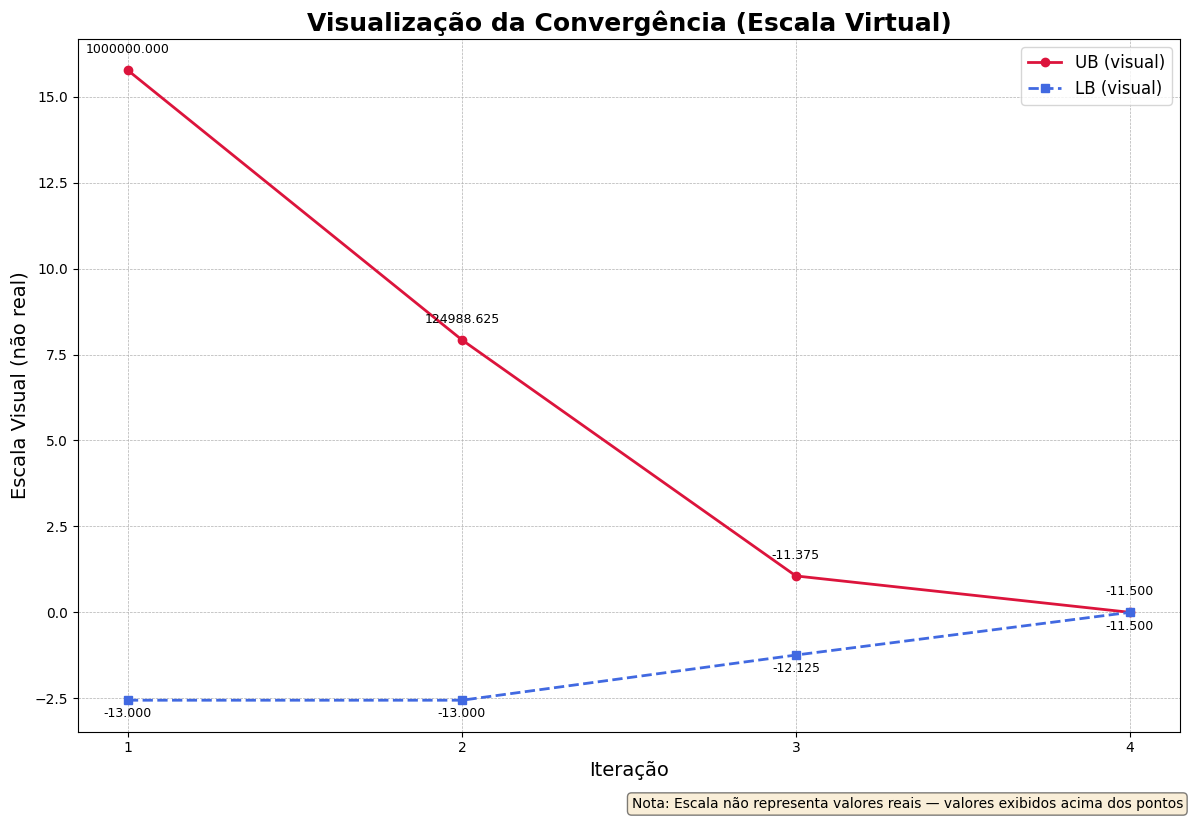

In [216]:
dw_solver.plot_convergence()

### Análise dos Resultados
---
#### 1. Resultado da Otimização
O algoritmo de Decomposição de Dantzig-Wolfe implementado foi capaz de resolver o problema com sucesso.

Ótimo Esperado: ```x = [2, 2.5]```

Ótimo Atingido pelo Código: ```x = [2.0, 2.5]```

Valor da Função Objetivo: ```-11.5```

A solução encontrada pelo código é idêntica à solução ótima esperada. O valor da função objetivo (```-2 * 2 - 3 * 2.5 = -11.5```) também está correto. Isso valida a capacidade do algoritmo de encontrar o ponto ótimo para este problema.

#### 2. Análise da Convergência
A análise dos limitantes (_bounds_) ao longo das iterações confirma o comportamento teórico esperado do algoritmo.

- **Limitantes Superiores (Upper Bounds - UB):** ```[1000000.0, 124988.625, -11.375, -11.5]```

    - Os valores extremamente altos nas duas primeiras iterações são um efeito esperado do método de inicialização **"Big M"**. Eles representam o custo de soluções que ainda contêm variáveis artificiais e não são, nesse momento, limitantes realistas para o problema original.

    - A partir da terceira iteração, quando as variáveis artificiais são removidas da solução, o UB passa a representar um valor factível e se comporta corretamente, diminuindo em direção ao ótimo (```-11.375 -> -11.5```).

- **Limitantes Inferiores (Lower Bounds - LB):** ```[-13.0, -13.0, -12.125, -11.5]```

    - O limitante inferior se comporta de maneira ideal, sendo **monotonicamente não-decrescente**. A cada iteração, ele fornece uma garantia cada vez mais precisa sobre o menor valor possível para a função objetivo, subindo de ```-13.0``` até convergir.

#### 3. Conclusão
O algoritmo funcionou perfeitamente para este caso. A convergência dos limitantes superior e inferior para o mesmo valor (```-11.5```) na quarta iteração garante, matematicamente, que a solução encontrada é o ótimo global. O "gap" entre os limitantes foi fechado, satisfazendo o critério de otimalidade.

---

## 2) Modelo Original

$$
\begin{aligned}
\text{Minimizar} \quad & Z = -2x_1 - x_2 - 3x_3 - x_4 \\
\text{sujeito a} \quad
& x_1 + x_2 + x_3 + x_4 \leq 6 \\
& x_2 + 2x_3 + x_4 \leq 4 \\
& \\
& x_1 + x_2 \leq 6 \\
& x_2 \leq 2 \\
& \\
& -x_3 + x_4 \leq 3 \\
& x_3 + x_4 \leq 5 \\
& \\
& x_1, x_2, x_3, x_4 \geq 0
\end{aligned}
$$

---

## Decomposição para Dantzig-Wolfe

Este modelo possui uma estrutura natural de blocos, onde as duas primeiras restrições acoplam os dois conjuntos de variáveis.

### 1. Problema Mestre

* **Restrições de Acoplamento:**
    $$
    \begin{aligned}
    x_1 + x_2 + x_3 + x_4 &\leq 6 \\
    x_2 + 2x_3 + x_4 &\leq 4
    \end{aligned}
    $$

* **Lado Direito (`master_b`):**
    ```python
    master_b = [6, 4]
    ```

### 2. Subproblema 1 (Bloco X1: Variáveis `x1`, `x2`)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -2x_1 - x_2 $
    ```python
    'c': np.array([-2, -1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 1], [0, 1]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    x_1 + x_2 &\leq 6 \\
    x_2 &\leq 2 \\
    x_1, x_2 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[1, 1], [0, 1]])
    'b_sub': np.array([6, 2])
    ```

### 3. Subproblema 2 (Bloco X2: Variáveis `x3`, `x4`)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -3x_3 - x_4 $
    ```python
    'c': np.array([-3, -1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 1], [2, 1]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    -x_3 + x_4 &\leq 3 \\
    x_3 + x_4 &\leq 5 \\
    x_3, x_4 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[-1, 1], [1, 1]])
    'b_sub': np.array([3, 5])
    ```
---
**Ótimo esperado:** <br>
Valor Ótimo da Função Objetivo: -14.000000 <br>
Valores das Variáveis de Decisão: <br>
  - Solução Bloco 1 (x1, x2): [4. 0.] <br>
  - Solução Bloco 2 (x3, x4): [2. 0.] <br>


In [217]:
# --- Definindo o problema de exemplo com 2 subproblemas ---
master_b = [6, 4]
subproblems_list = [
    # Subproblema 1 (x1, x2)
    {
        'c': np.array([-2, -1]),
        'A_master': np.array([[1, 1], [0, 1]]),
        'A_sub': np.array([[1, 1], [0, 1]]),
        'b_sub': np.array([6, 2]),
    },
    # Subproblema 2 (x3, x4)
    {
        'c': np.array([-3, -1]),
        'A_master': np.array([[1, 1], [2, 1]]),
        'A_sub': np.array([[-1, 1], [1, 1]]),
        'b_sub': np.array([3, 5]),
    }
]

dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    num_vars_x1 = len(subproblems_list[0]['c'])
    solution_x1 = final_solution[:num_vars_x1]
    solution_x2 = final_solution[num_vars_x1:]
    print(f"  - Solução Bloco 1 (x1, x2): {np.round(solution_x1, 4)}")
    print(f"  - Solução Bloco 2 (x3, x4): {np.round(solution_x2, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 2
Número de subproblemas: 2
Número total de variáveis originais: 4

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 2000000.000000
Custo Reduzido Mínimo: -1000015.000000
Melhor Limitante Inferior (LB) encontrado: -27.000000
Adicionando nova proposta do subproblema 1.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 1599994.000000
Custo Reduzido Mínimo: -1000012.000000
Melhor Limitante Inferior (LB) encontrado: -27.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: 933319.333333
Custo Reduzido Mínimo: -1000000.000000
Melhor Limitante Inferior (LB) encontrado: -27.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 4 ---
Melhor Limitante Superior (UB) encontrado: 599986.000000
Custo Reduzido Mínimo: -1000000.000000
Melhor Limitante Inferior (LB) encontrado: -27.000000
Adicionando nova proposta do subproblema 1.

--- Iteração 5 --

In [218]:
dw_solver.get_convergence_history()

{'lower_bounds': [-27.0, -27.0, -27.0, -27.0, -14.0],
 'upper_bounds': [2000000.0, 1599994.0, 933319.3333333333, 599986.0, -14.0]}

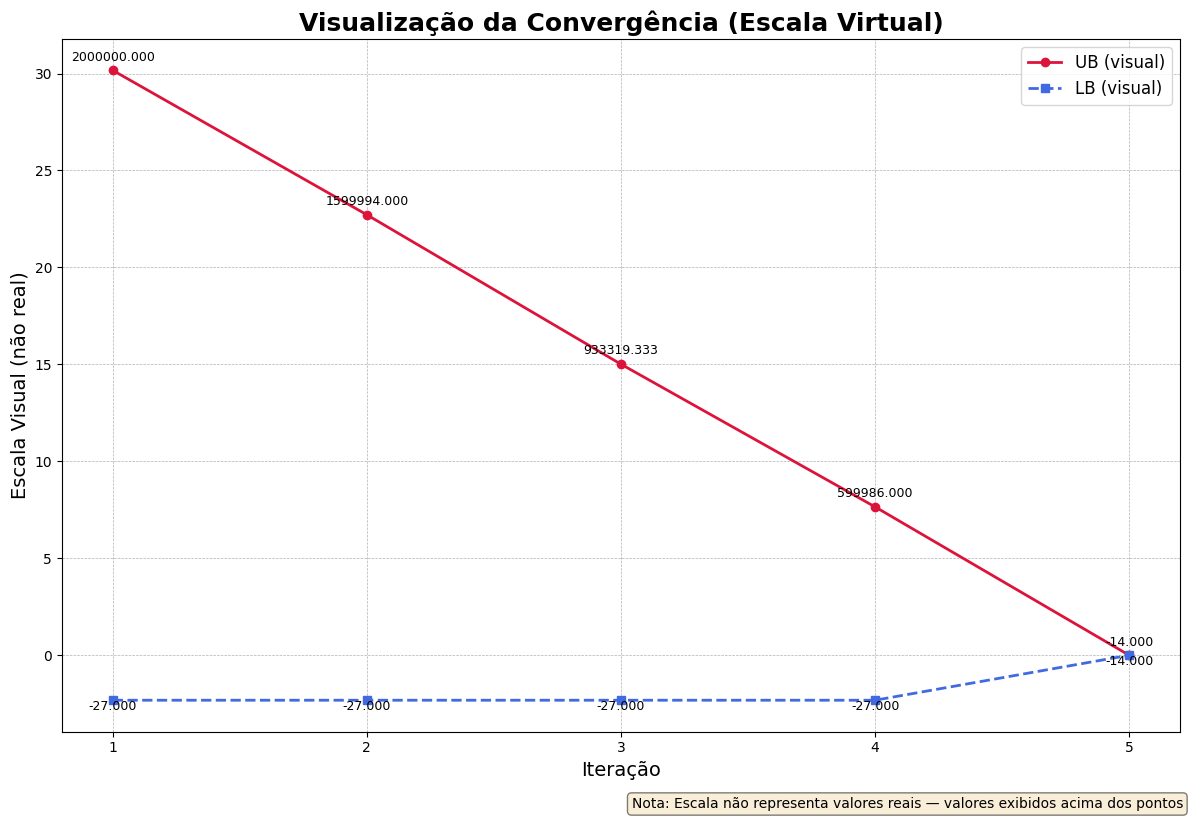

In [219]:
dw_solver.plot_convergence()

### Convertido em apenas um bloco
---
**Ótimo esperado:**<br>
Valor Ótimo da Função Objetivo: -14.000000<br>
Valores das Variáveis de Decisão:<br>
  - Solução (x1, x2, x3, x4): [4. 0. 2. 0.]

In [220]:

master_b = [6, 4]

subproblems_list = [
    # Subproblema único contendo todas as variáveis e restrições de bloco
    {
        'c': np.array([-2, -1, -3, -1]),
        'A_master': np.array([
            [1, 1, 1, 1],
            [0, 1, 2, 1]
        ]),
        'A_sub': np.array([
            [1, 1,  0,  0],
            [0, 1,  0,  0],
            [0, 0, -1,  1],
            [0, 0,  1,  1]
        ]),
        'b_sub': np.array([6, 2, 3, 5]),
    }
]

dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    print(f"  - Solução (x1, x2, x3, x4): {np.round(final_solution, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 2
Número de subproblemas: 1
Número total de variáveis originais: 4

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 1000000.000000
Custo Reduzido Mínimo: -1000027.000000
Melhor Limitante Inferior (LB) encontrado: -27.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 599989.200000
Custo Reduzido Mínimo: -1000012.000000
Melhor Limitante Inferior (LB) encontrado: -27.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: -12.000000
Custo Reduzido Mínimo: -6.000000
Melhor Limitante Inferior (LB) encontrado: -18.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 4 ---
Melhor Limitante Superior (UB) encontrado: -14.000000
Custo Reduzido Mínimo: 0.000000
Melhor Limitante Inferior (LB) encontrado: -14.000000

Condição de otimalidade atingida. Solução final encontrada.

Reconstruindo a solu

In [221]:
dw_solver.get_convergence_history()

{'lower_bounds': [-27.0, -27.0, -18.000000000000004, -14.0],
 'upper_bounds': [1000000.0, 599989.2, -12.0, -14.0]}

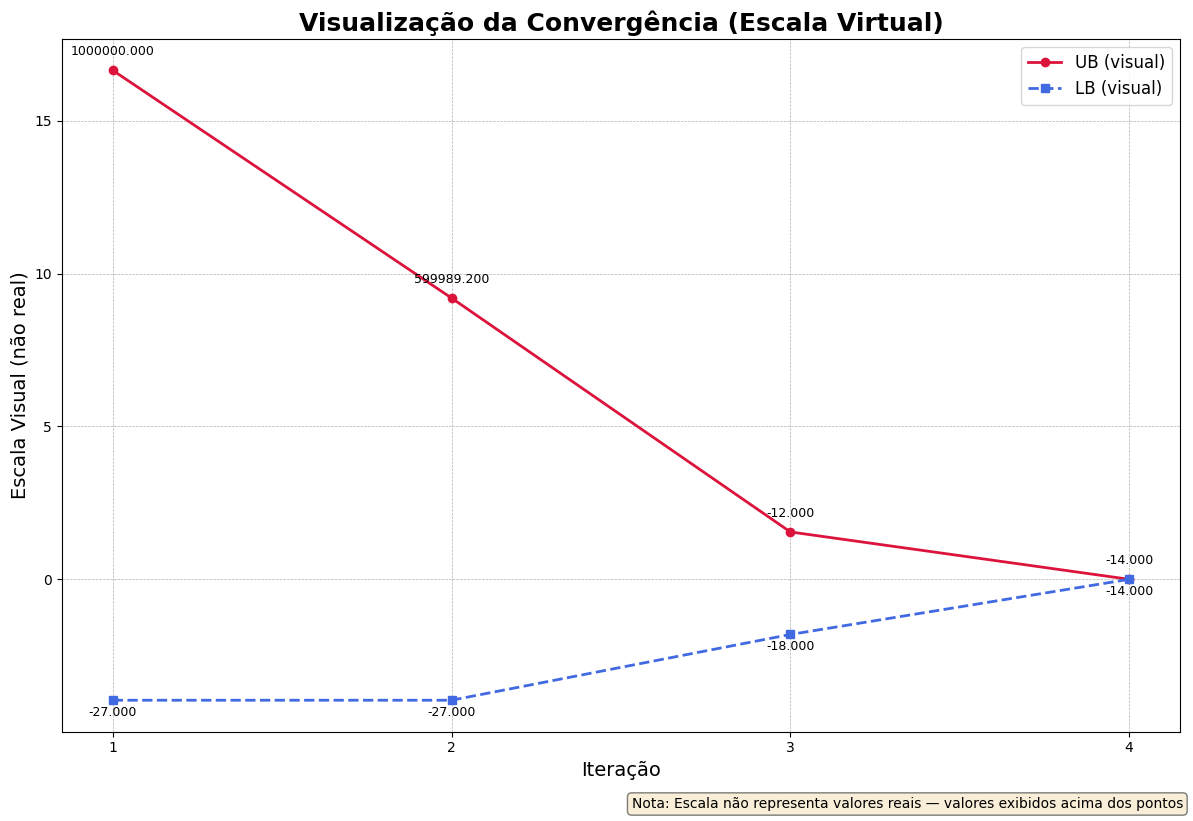

In [222]:
dw_solver.plot_convergence()

### Análise dos Resultados
---
#### 1. Resultado da Otimização
O algoritmo foi testado neste modelo usando duas estratégias de decomposição diferentes: uma com **dois subproblemas** (Blocos X1 e X2) e outra com um **único subproblema unificado**.

- **Ótimo Esperado:** ```x = [4.0, 0.0, 2.0, 0.0]```, com ```Z = -14.0```

- **Ótimo Atingido (Ambas as Estratégias):** ```x = [4.0, 0.0, 2.0, 0.0]```, com ```Z = -14.0```

Ambas as abordagens de decomposição encontraram a solução ótima correta, validando a robustez da implementação.

#### 2. Análise da Convergência e Comparação das Estratégias
A principal diferença entre as duas abordagens foi a **velocidade de convergência**.

- **Estratégia 1 (Dois Blocos):**

    - Limitantes: ```UB: [2e6, 1.6e6, 9.3e5, 6e5, -14.0]```, ```LB: [-27.0, -27.0, -27.0, -27.0, -14.0]```

    - O algoritmo precisou de **5 iterações** para convergir. O Limitante Inferior (LB) permaneceu estagnado em ```-27.0 ```durante quase todo o processo, só melhorando na última iteração.

- **Estratégia 2 (Um Bloco Unificado):**

    - Limitantes: UB: ```[1e6, 6e5, -12.0, -14.0]```, LB: ```[-27.0, -27.0, -18.0, -14.0]```

    - O algoritmo convergiu em apenas **4 iterações**. Notavelmente, o Limitante Inferior (LB) começou a melhorar mais cedo (na 3ª iteração, de ```-27.0``` para ```-18.0```), indicando que as propostas geradas pelo subproblema maior eram mais "informativas" para o Problema Mestre.

#### 3. Conclusão
Embora ambas as estratégias de decomposição sejam válidas e levem à solução ótima, este exemplo ilustra um ponto fundamental: **a forma como um problema é decomposto pode impactar diretamente a eficiência do algoritmo**. Unificar os blocos em um único subproblema, neste caso, resultou em uma convergência mais rápida, pois permitiu gerar colunas que melhoraram o limitante inferior mais cedo no processo.

---

## 3) Modelo Original

$$
\begin{aligned}
\text{Minimizar} \quad & Z = x_1 + x_2 - 3x_3 + 3x_4 \\
\text{sujeito a} \quad
& x_1 + 2x_2 + 3x_3 + 3x_4 \leq 4 \\
& \\
& 2x_1 + x_2 \leq 2 \\
& \\
& 4x_3 + x_4 \leq 4 \\
& \\
& x_1, x_2, x_3, x_4 \geq 0
\end{aligned}
$$

---

## Decomposição para Dantzig-Wolfe

Este modelo também possui uma estrutura de blocos clara, com a primeira restrição servindo como restrição de acoplamento.

### 1. Problema Mestre

* **Restrição de Acoplamento:**
    $$
    \begin{aligned}
    x_1 + 2x_2 + 3x_3 + 3x_4 &\leq 4
    \end{aligned}
    $$

* **Lado Direito (`master_b`):**
    ```python
    master_b = [4]
    ```

### 2. Subproblema 1 (Bloco X1: Variáveis `x1`, `x2`)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad x_1 + x_2 $
    ```python
    'c': np.array([1, 1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 2]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    2x_1 + x_2 &\leq 2 \\
    x_1, x_2 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[2, 1]])
    'b_sub': np.array([2])
    ```

### 3. Subproblema 2 (Bloco X2: Variáveis `x3`, `x4`)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -3x_3 + 3x_4 $
    ```python
    'c': np.array([-3, 3])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[3, 3]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    4x_3 + x_4 &\leq 4 \\
    x_3, x_4 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[4, 1]])
    'b_sub': np.array([4])
    ```
---

**Ótimo esperado:**<br>
Valor Ótimo da Função Objetivo: -3.000000<br>
Valores das Variáveis de Decisão:<br>
  - Solução Bloco 1 (x1, x2): [0. 0.]<br>
  - Solução Bloco 2 (x3, x4): [1. 0.]

In [223]:
master_b = [4]
subproblems_list = [
    # Subproblema 1 (x1, x2)
    {
        'c': np.array([1, 1]),
        'A_master': np.array([[1, 2]]),
        'A_sub': np.array([[2, 1]]),
        'b_sub': np.array([2]),
    },
    # Subproblema 2 (x3, x4)
    {
        'c': np.array([-3, 3]),
        'A_master': np.array([[3, 3]]),
        'A_sub': np.array([[4, 1]]),
        'b_sub': np.array([4]),
    }
]

dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    num_vars_x1 = len(subproblems_list[0]['c'])
    solution_x1 = final_solution[:num_vars_x1]
    solution_x2 = final_solution[num_vars_x1:]
    print(f"  - Solução Bloco 1 (x1, x2): {np.round(solution_x1, 4)}")
    print(f"  - Solução Bloco 2 (x3, x4): {np.round(solution_x2, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 1
Número de subproblemas: 2
Número total de variáveis originais: 4

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 2000000.000000
Custo Reduzido Mínimo: -1000003.000000
Melhor Limitante Inferior (LB) encontrado: -3.000000
Adicionando nova proposta do subproblema 1.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 999997.000000
Custo Reduzido Mínimo: -1000000.000000
Melhor Limitante Inferior (LB) encontrado: -3.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: -3.000000
Custo Reduzido Mínimo: 0.000000
Melhor Limitante Inferior (LB) encontrado: -3.000000

Condição de otimalidade atingida. Solução final encontrada.

Reconstruindo a solução final...
Pesos (α) da solução final:
  - Proposta 3 (do subproblema 1): α = 1.0000
  - Proposta 4 (do subproblema 0): α = 1.0000


================= RESULTADO FINAL =================
Valor Ótimo da Função 

In [224]:
dw_solver.get_convergence_history()

{'lower_bounds': [-3.0, -3.0, -3.0],
 'upper_bounds': [2000000.0, 999997.0, -3.0]}

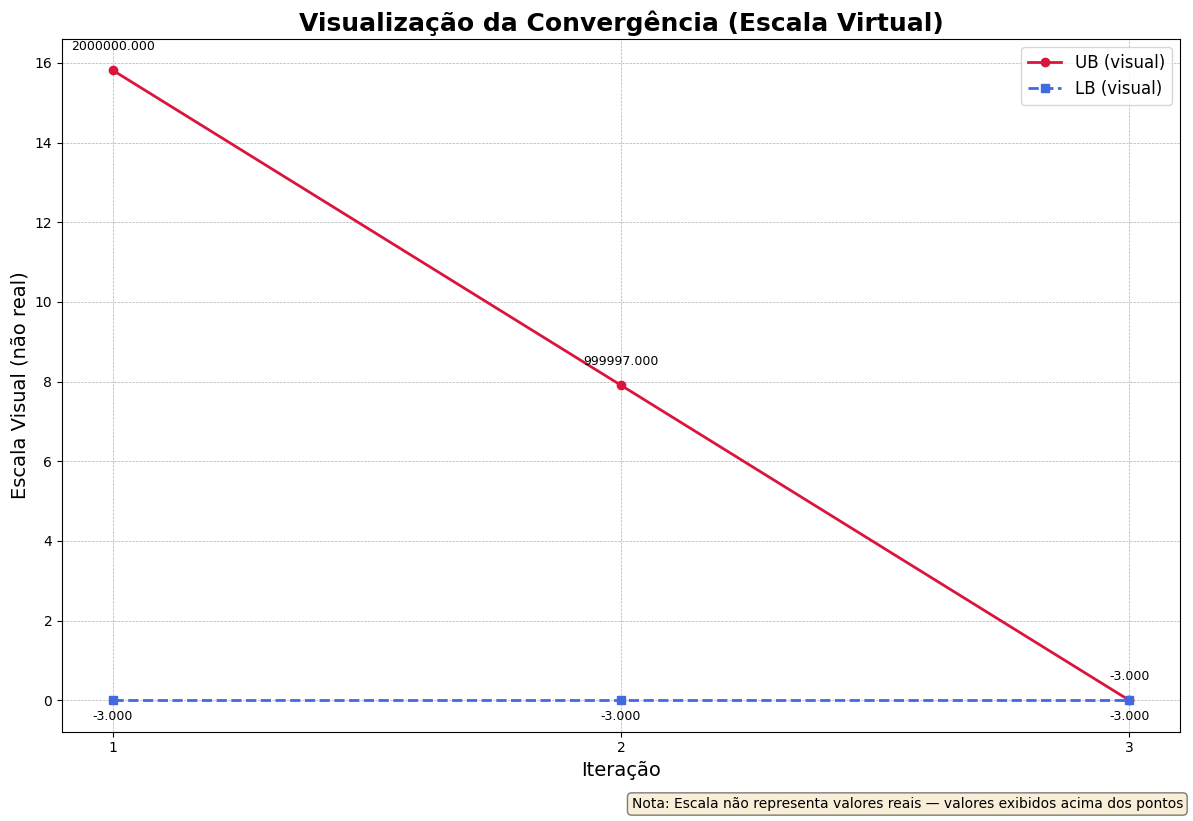

In [225]:
dw_solver.plot_convergence()

### Análise dos Resultados
---
#### 1. Resultado da Otimização
O algoritmo foi aplicado a um problema com uma única restrição de acoplamento e dois subproblemas.

- **Ótimo Esperado:** ```x = [0.0, 0.0, 1.0, 0.0]```, com ```Z = -3.0```

- **Ótimo Atingido pelo Código:** ```x = [0.0, 0.0, 1.0, 0.0]```, com ```Z = -3.0```

A solução encontrada é exatamente a mesma que a esperada, confirmando a correção do resultado.

#### 2. Análise da Convergência
Este caso apresentou uma convergência extremamente rápida e um comportamento de limitantes notável.

- **Limitantes:** ```UB: [2e6, 1e6, -3.0]```, ```LB: [-3.0, -3.0, -3.0]```

- **Iterações para Convergência:** 3

O ponto mais interessante aqui é o comportamento do **Limitante Inferior (LB)**. Ele foi calculado como ```-3.0``` já na primeira iteração e permaneceu nesse valor até o final. Isso indica que a relaxação inicial do problema (mesmo com as variáveis artificiais) já forneceu uma garantia muito forte sobre o valor ótimo.

O **Limitante Superior (UB)** seguiu o padrão esperado, começando com valores muito altos devido ao "Big M" e caindo drasticamente para o valor ótimo na terceira iteração, momento em que encontrou o LB.

#### 3. Conclusão
O algoritmo resolveu o problema de forma eficiente e correta. A convergência em apenas 3 iterações, impulsionada por um Limitante Inferior que já "nasceu" no valor ótimo, demonstra como a estrutura de certos problemas pode ser particularmente favorável à decomposição, levando a uma resolução muito rápida.

---

### Decomposição em Bloco Único

Para decompor o modelo em uma estrutura com um único subproblema, seguimos uma lógica direta:

1.  **Identificar a Restrição de Acoplamento:** A primeira restrição, `x₁ + 2x₂ + 3x₃ + 3x₄ ≤ 4`, é a única que "conecta" todas as variáveis. Ela será a única restrição do **Problema Mestre**.

2.  **Definir o Subproblema Único:** Todas as outras restrições (`2x₁ + x₂ ≤ 2` e `4x₃ + x₄ ≤ 4`), juntamente com as condições de não-negatividade, definem a região factível `X` de um **único e maior Subproblema**.

Ao construir a matriz de restrições deste subproblema (`A_sub`), devemos garantir que ela tenha o número correto de colunas (uma para cada variável: `x₁`, `x₂`, `x₃`, `x₄`), preenchendo com zeros as posições das variáveis que não aparecem em uma determinada restrição.

---

### 1. Problema Mestre

* **Restrição de Acoplamento:**
    $$
    \begin{aligned}
    x_1 + 2x_2 + 3x_3 + 3x_4 &\leq 4
    \end{aligned}
    $$

* **Lado Direito (`master_b`):**
    ```python
    master_b = [4]
    ```

### 2. Subproblema (Único)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad x_1 + x_2 - 3x_3 + 3x_4 $
    ```python
    'c': np.array([1, 1, -3, 3])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 2, 3, 3]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    2x_1 + x_2 &\leq 2 \\
    4x_3 + x_4 &\leq 4 \\
    x_1, x_2, x_3, x_4 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([
        [2, 1, 0, 0],
        [0, 0, 4, 1]
    ])
    'b_sub': np.array([2, 4])
    ```

---
### 3. Solução Ótima
* **Valor da Função Objetivo:** -3.000000
* **Valores das Variáveis de Decisão:**
    * Solução (x1, x2, x3, x4): `[0. 0. 1. 0.]`


In [226]:
master_b = [4]
master_signs = ['<='] 

subproblems_list = [
    # Subproblema único contendo todas as variáveis e restrições de bloco
    {
        'c': np.array([1, 1, -3, 3]),
        'A_master': np.array([[1, 2, 3, 3]]),
        
        # Matriz A_sub com 4 colunas (para x1, x2, x3, x4)
        'A_sub': np.array([
            [2, 1, 0, 0],  # Restrição 2x₁ + x₂ ≤ 2
            [0, 0, 4, 1]   # Restrição 4x₃ + x₄ ≤ 4
        ]),
        'b_sub': np.array([2, 4]),
    }
]

dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    print(f"  - Solução (x1, x2, x3, x4): {np.round(final_solution, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 1
Número de subproblemas: 1
Número total de variáveis originais: 4

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 1000000.000000
Custo Reduzido Mínimo: -1000003.000000
Melhor Limitante Inferior (LB) encontrado: -3.000000
Adicionando nova proposta do subproblema 0.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: -3.000000
Custo Reduzido Mínimo: 0.000000
Melhor Limitante Inferior (LB) encontrado: -3.000000

Condição de otimalidade atingida. Solução final encontrada.

Reconstruindo a solução final...
Pesos (α) da solução final:
  - Proposta 2 (do subproblema 0): α = 1.0000


================= RESULTADO FINAL =================
Valor Ótimo da Função Objetivo: -3.000000
Valores das Variáveis de Decisão:
  - Solução (x1, x2, x3, x4): [0. 0. 1. 0.]


In [227]:
dw_solver.get_convergence_history()

{'lower_bounds': [-3.0, -3.0], 'upper_bounds': [1000000.0, -3.0]}

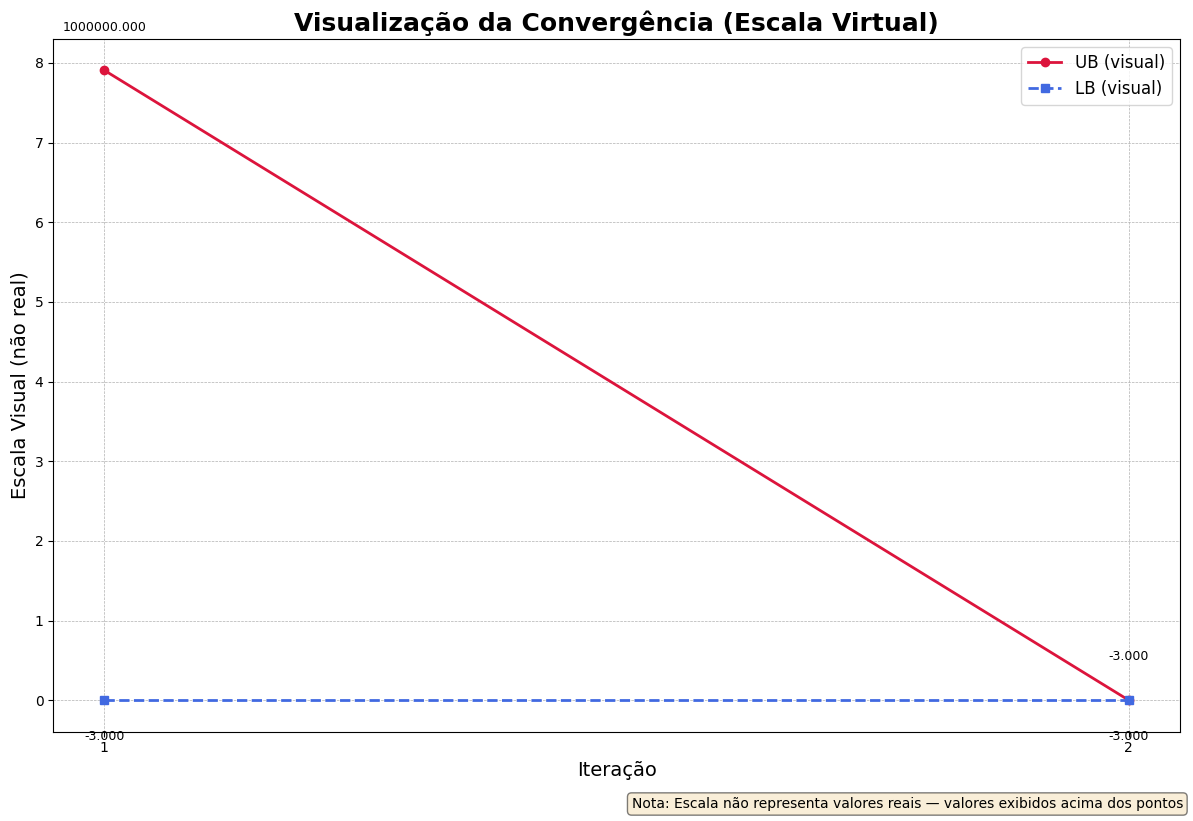

In [228]:
dw_solver.plot_convergence()

### Análise dos Resultados (Comparativo)
---
#### 1. Resultado da Otimização
O algoritmo foi testado neste modelo usando duas estratégias de decomposição: uma com **dois subproblemas** e outra com um **único subproblema unificado**.

- **Ótimo Esperado:** ```x = [0.0, 0.0, 1.0, 0.0]```, com ```Z = -3.0```

- **Ótimo Atingido (Ambas as Estratégias):** ```x = [0.0, 0.0, 1.0, 0.0]```, com ```Z = -3.0```

Ambas as abordagens de decomposição encontraram a solução ótima correta, validando a robustez da implementação.

#### 2. Análise da Convergência e Comparação das Estratégias
Este caso é notável pela **convergência extremamente rápida** em ambas as estratégias, embora a abordagem de bloco único tenha se mostrado ainda mais eficiente.

- **Estratégia 1 (Dois Blocos):**

    - *Iterações*: ```3```

    - *Limitantes*: ```UB: [2e6, 1e6, -3.0]```, ```LB: [-3.0, -3.0, -3.0]```

    - O algoritmo convergiu em ```3``` iterações.

- **Estratégia 2 (Um Bloco Unificado):**

    -*Iterações*: ```2```

    -*Limitantes*: ```UB: [1e6, -3.0]```, ```LB: [-3.0, -3.0]```

    O algoritmo convergiu em apenas ```2``` iterações.

O ponto chave em ambas as abordagens é o comportamento do **Limitante Inferior (LB)**, que atingiu o valor ótimo de ```-3.0``` desde a primeira iteração. Isso indica que a estrutura do problema é tal que a relaxação inicial já fornece uma garantia muito forte sobre a solução.

#### 3. Conclusão
Embora ambas as estratégias tenham sido muito eficientes, a decomposição em bloco único foi superior, resolvendo o problema em apenas duas iterações.

Isso sugere que, para este problema, o subproblema unificado foi capaz de encontrar a proposta ótima (```x = [0, 0, 1, 0]```) imediatamente na primeira iteração de "pricing" (após a inicialização). A abordagem de dois blocos precisou de uma iteração extra para coordenar as propostas de cada subproblema antes de encontrar a combinação ótima. Este exemplo demonstra que, mesmo em problemas com estrutura de blocos natural, uma decomposição mais simples pode, em alguns casos, levar a uma performance computacional melhor.

---

## 
<div style=" border-left: 6px solid #2196F3; padding: 10px 20px; margin: 20px 0;">
<h4>Fonte do Exemplo</h4>
<p>O exemplo foi retirado do <strong>Capítulo 7</strong> do livro de Bazaraa, começando na <strong>página 311</strong> (Seção 7.2 <em>Numerical Example</em>).</p>
<a href="https://herivelto.wordpress.com/wp-content/uploads/2011/01/linear-programming-and-network-flows-bazaraa.pdf" target="_blank" rel="noopener noreferrer">Consultar o livro</a>
</div>

## 4) Modelo Original

$$
\begin{aligned}
\text{Minimizar} \quad & Z = -2x_1 -x_2 -x_3 +x_4 \\
\text{sujeito a} \quad
& x_1 + x_3 \leq 2 \\
& x_1 + x_2 + 2x_4 \leq 3 \\
& \\
& x_1 \leq 2 \\
& x_1 + 2x_2 \leq 5 \\
& \\
& -x_3 + x_4 \leq 2 \\
& 2x_3 + x_4 \leq 6 \\
& \\
& x_1, x_2, x_3, x_4 \geq 0
\end{aligned}
$$

---

## Decomposição para Dantzig-Wolfe

Este modelo possui uma estrutura de blocos onde as duas primeiras restrições acoplam os dois conjuntos de variáveis.

### 1. Problema Mestre

* **Restrições de Acoplamento:**
    $$
    \begin{aligned}
    x_1 + x_3 &\leq 2 \\
    x_1 + x_2 + 2x_4 &\leq 3
    \end{aligned}
    $$

* **Lado Direito (`master_b`):**
    ```python
    master_b = [2, 3]
    ```

### 2. Subproblema 1 (Bloco X1: Variáveis `x1`, `x2`)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -2x_1 - x_2 $
    ```python
    'c': np.array([-2, -1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 0], [1, 1]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    x_1 &\leq 2 \\
    x_1 + 2x_2 &\leq 5 \\
    x_1, x_2 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[1, 0], [1, 2]])
    'b_sub': np.array([2, 5])
    ```

### 3. Subproblema 2 (Bloco X2: Variáveis `x3`, `x4`)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -x_3 + x_4 $
    ```python
    'c': np.array([-1, 1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[1, 0], [0, 2]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    -x_3 + x_4 &\leq 2 \\
    2x_3 + x_4 &\leq 6 \\
    x_3, x_4 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[-1, 1], [2, 1]])
    'b_sub': np.array([2, 6])
    ```

### 4. Solução Ótima
$$
    \begin{aligned}
    x_1 = 1 \quad
    x_2 = 2 \quad
    x_3 = 1 \quad
    x_4 = 0
    \end{aligned}
    $$

> Acredito pode ser **degenerada** pois  DW e o Simplex apresentam solução  (2, 1, 0, 0) factível (f(x) = -5), entretanro, no livro e por pontos interiores (aproximado) temos a ótima esperada.

In [229]:
master_b = [2, 3]
subproblems_list = [
    # Subproblema 1 (x1, x2)
    {
        'c': np.array([-2, -1]),
        'A_master': np.array([[1, 0], [1, 1]]),
        'A_sub': np.array([[1, 0], [1, 2]]),
        'b_sub': np.array([2, 5]),
    },
    # Subproblema 2 (x3, x4)
    {
        'c': np.array([-1, 1]),
        'A_master': np.array([[1, 0], [0, 2]]),
        'A_sub': np.array([[-1, 1], [2, 1]]),
        'b_sub': np.array([2, 6]),
    }
]

dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    num_vars_x1 = len(subproblems_list[0]['c'])
    solution_x1 = final_solution[:num_vars_x1]
    solution_x2 = final_solution[num_vars_x1:]
    print(f"  - Solução Bloco 1 (x1, x2): {np.round(solution_x1, 4)}")
    print(f"  - Solução Bloco 2 (x3, x4): {np.round(solution_x2, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 2
Número de subproblemas: 2
Número total de variáveis originais: 4

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 2000000.000000
Custo Reduzido Mínimo: -1000005.500000
Melhor Limitante Inferior (LB) encontrado: -8.500000
Adicionando nova proposta do subproblema 0.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 1142852.428571
Custo Reduzido Mínimo: -1000003.000000
Melhor Limitante Inferior (LB) encontrado: -8.500000
Adicionando nova proposta do subproblema 1.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: 1047614.047619
Custo Reduzido Mínimo: -1000000.000000
Melhor Limitante Inferior (LB) encontrado: -8.500000
Adicionando nova proposta do subproblema 0.

--- Iteração 4 ---
Melhor Limitante Superior (UB) encontrado: 333331.333333
Custo Reduzido Mínimo: -1000000.000000
Melhor Limitante Inferior (LB) encontrado: -8.500000
Adicionando nova proposta do subproblema 1.

--- Iteração 5 ---
M

In [230]:
dw_solver.get_convergence_history()

{'lower_bounds': [-8.5, -8.5, -8.5, -8.5, -5.0],
 'upper_bounds': [2000000.0,
  1142852.4285714286,
  1047614.0476190476,
  333331.3333333334,
  -5.0]}

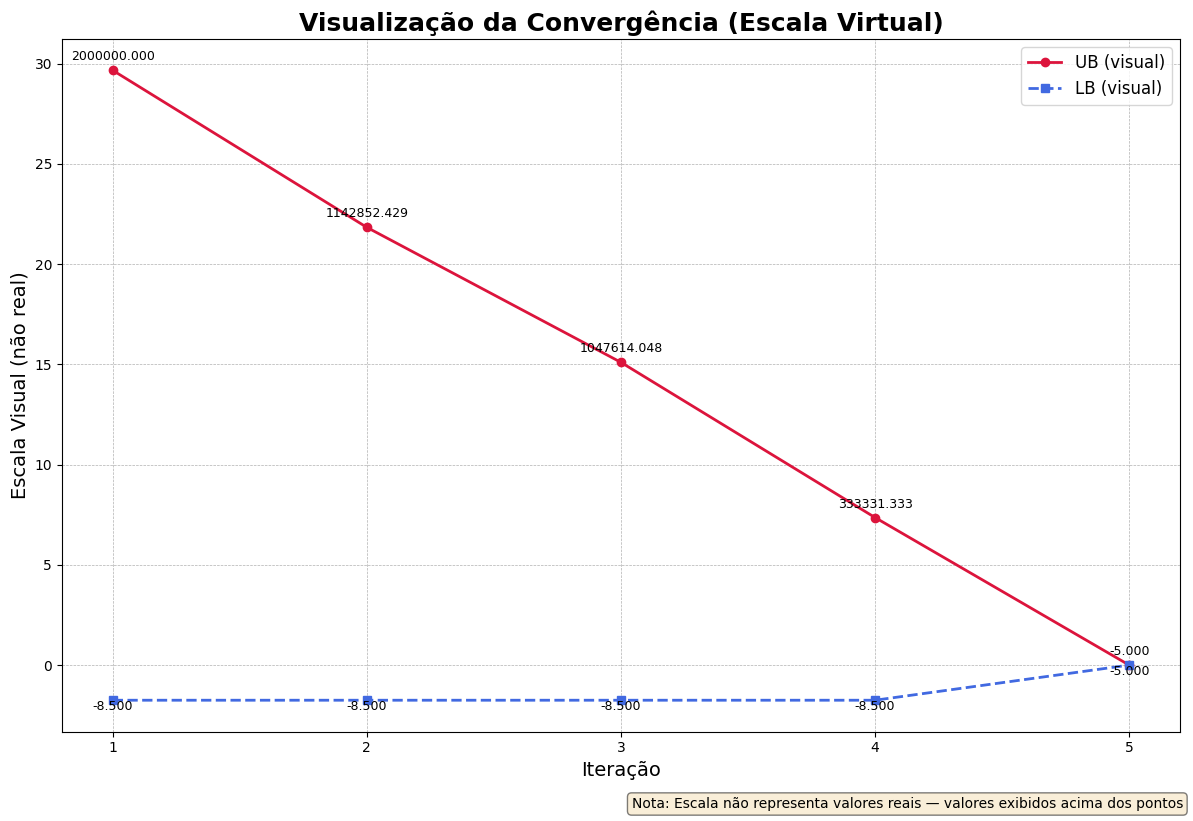

In [231]:
dw_solver.plot_convergence()

### Análise dos Resultados
---
#### 1. Resultado da Otimização e Múltiplas Soluções
Este caso é particularmente interessante pois o problema possui múltiplas soluções ótimas.

- **Ótimo Esperado (do livro):** ```x = [1, 2, 1, 0]```, com ```Z = -5.0```

- **Outra Solução Ótima (identificada pelo usuário):** ```x = [2, 1, 0, 0]```, com ```Z = -5.0```

- **Ótimo Atingido pelo Código:** ```x = [1.7143, 1.2857, 0.2857, 0.0]```, com ```Z = -5.0```

O algoritmo **encontrou o valor ótimo correto (```-5.0```)**. A solução encontrada pelo código é diferente da solução do livro. Essa divergência, aliada ao fato de que todas as soluções válidas atingem o mesmo valor ótimo, sugere fortemente que o problema possui múltiplas soluções ótimas. A solução do Dantzig-Wolfe é uma combinação convexa das propostas (pontos extremos) geradas, e o ponto final depende do caminho que o algoritmo percorre. O fato de todas as soluções terem o mesmo valor de função objetivo valida que o código encontrou uma solução pertencente ao conjunto de ótimos.

#### 2. Análise da Convergência
O comportamento dos limitantes confirma a correção do processo.

- **Limitantes:** ```UB: [2e6, 1.14e6, 1.05e6, 3.33e5, -5.0]```, ```LB: [-8.5, -8.5, -8.5, -8.5, -5.0]```

- **Iterações para Convergência:** ```5```

Os limitantes superior e inferior se comportaram de maneira teoricamente correta, sendo não-crescente e não-decrescente, respectivamente. A convergência de ambos para o valor ```-5.0``` na quinta iteração fornece a prova matemática de que a otimalidade foi alcançada.

#### 3. Conclusão
O algoritmo resolveu o problema com sucesso, encontrando o valor ótimo correto. A diferença entre o vetor solução encontrado e o esperado é explicada pela existência de múltiplas soluções ótimas, um fenômeno comum em programação linear. O importante é que o valor da função objetivo é o mesmo, validando o resultado.

---

### Decomposição em Bloco Único

Para decompor o modelo em uma estrutura com um único subproblema, seguimos uma lógica direta:

1.  **Identificar as Restrições de Acoplamento:** As duas primeiras restrições, `x₁ + x₃ ≤ 2` e `x₁ + x₂ + 2x₄ ≤ 3`, são as que "conectam" todas as variáveis e, portanto, formarão as restrições do **Problema Mestre**.

2.  **Definir o Subproblema Único:** Todas as outras quatro restrições, que originalmente definiam os blocos separados, são agora agrupadas para formar a região factível `X` de um **único e maior Subproblema**.

Ao construir a matriz de restrições deste subproblema (`A_sub`), devemos garantir que ela tenha o número correto de colunas (uma para cada variável: `x₁`, `x₂`, `x₃`, `x₄`), preenchendo com zeros as posições das variáveis que não aparecem em uma determinada restrição.

---

#### 1. Problema Mestre

* **Restrições de Acoplamento:**
    $$
    \begin{aligned}
    x_1 + x_3 &\leq 2 \\
    x_1 + x_2 + 2x_4 &\leq 3
    \end{aligned}
    $$

* **Lado Direito (`master_b`):**
    ```python
    master_b = [2, 3]
    ```

#### 2. Subproblema (Único)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -2x_1 -x_2 -x_3 +x_4 $
    ```python
    'c': np.array([-2, -1, -1, 1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([
        [1, 0, 1, 0],
        [1, 1, 0, 2]
    ])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    x_1 &\leq 2 \\
    x_1 + 2x_2 &\leq 5 \\
    -x_3 + x_4 &\leq 2 \\
    2x_3 + x_4 &\leq 6 \\
    x_1, x_2, x_3, x_4 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([
        [1, 0,  0,  0],
        [1, 2,  0,  0],
        [0, 0, -1,  1],
        [0, 0,  2,  1]
    ])
    'b_sub': np.array([2, 5, 2, 6])
    ```

---
#### 3. Solução Ótima
* **Valor da Função Objetivo:** -5.0
* **Valores das Variáveis de Decisão:**
    * Solução (x1, x2, x3, x4): `[1. 2. 1. 0.]` ou `[2. 1. 0. 0.]` (múltiplos ótimos)


In [232]:
master_b = [2, 3]
master_signs = ['<=', '<='] 

subproblems_list = [
    # Subproblema único contendo todas as variáveis e restrições de bloco
    {
        'c': np.array([-2, -1, -1, 1]),
        'A_master': np.array([
            [1, 0, 1, 0],
            [1, 1, 0, 2]
        ]),
        
        # Matriz A_sub com 4 colunas (para x1, x2, x3, x4)
        'A_sub': np.array([
            [1, 0,  0,  0],  # Restrição x₁ ≤ 2
            [1, 2,  0,  0],  # Restrição x₁ + 2x₂ ≤ 5
            [0, 0, -1,  1],  # Restrição -x₃ + x₄ ≤ 2
            [0, 0,  2,  1]   # Restrição 2x₃ + x₄ ≤ 6
        ]),
        'b_sub': np.array([2, 5, 2, 6]),
        
    }
]

dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    print(f"  - Solução (x1, x2, x3, x4): {np.round(final_solution, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 2
Número de subproblemas: 1
Número total de variáveis originais: 4

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 1000000.000000
Custo Reduzido Mínimo: -1000008.500000
Melhor Limitante Inferior (LB) encontrado: -8.500000
Adicionando nova proposta do subproblema 0.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 599996.600000
Custo Reduzido Mínimo: -1000002.500000
Melhor Limitante Inferior (LB) encontrado: -8.500000
Adicionando nova proposta do subproblema 0.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: -4.900000
Custo Reduzido Mínimo: -0.600000
Melhor Limitante Inferior (LB) encontrado: -5.500000
Adicionando nova proposta do subproblema 0.

--- Iteração 4 ---
Melhor Limitante Superior (UB) encontrado: -5.000000
Custo Reduzido Mínimo: -0.000000
Melhor Limitante Inferior (LB) encontrado: -5.000000

Condição de otimalidade atingida. Solução final encontrada.

Reconstruindo a solução f

In [233]:
dw_solver.get_convergence_history()

{'lower_bounds': [-8.5, -8.5, -5.5, -4.999999999999995],
 'upper_bounds': [1000000.0, 599996.6, -4.9, -4.999999999999995]}

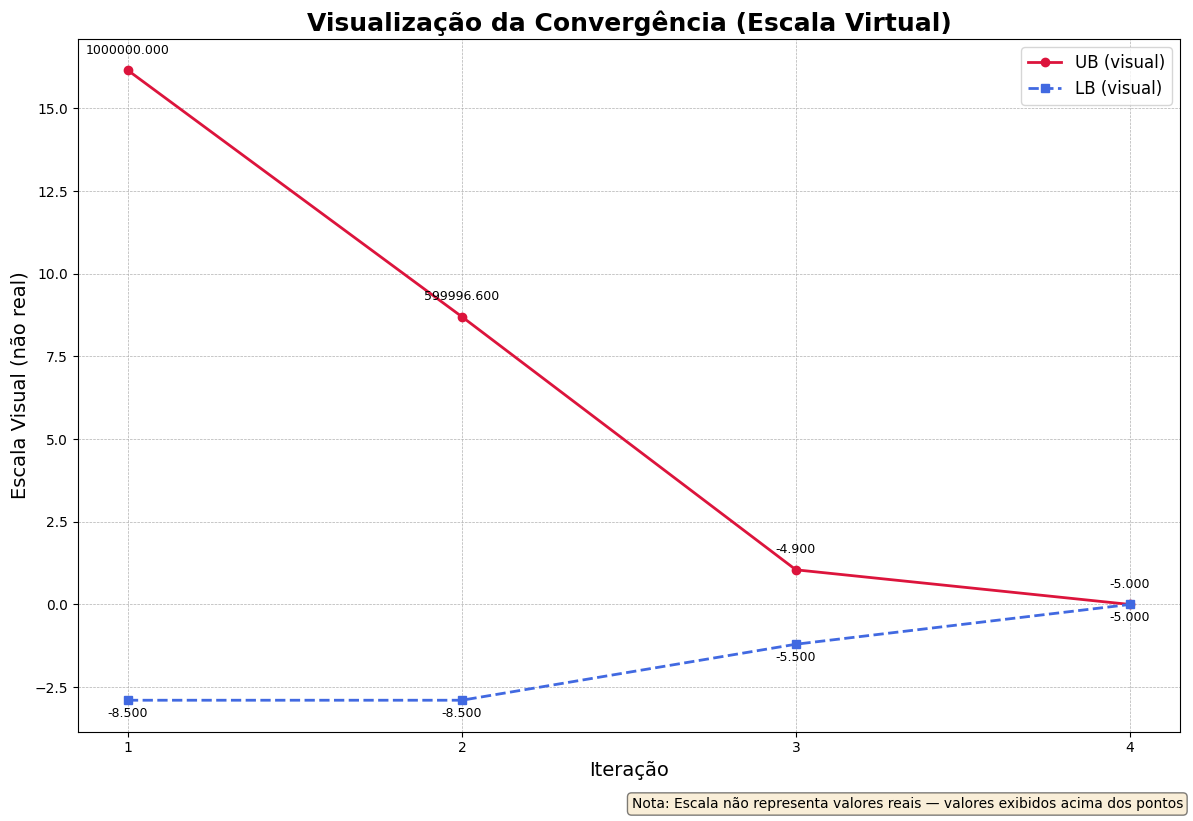

In [234]:
dw_solver.plot_convergence()

### Análise dos Resultados (Comparativo)
---
#### 1. Resultado da Otimização e Comparação de Soluções
O algoritmo foi testado neste modelo usando duas estratégias de decomposição diferentes: uma com **dois subproblemas** e outra com um **único subproblema unificado**.

- **Ótimo Esperado (do livro):** ```x = [1, 2, 1, 0]```, com ```Z = -5.0```

- **Ótimo Atingido (Ambas as Estratégias):** ```Z = -5.0```

Ambas as abordagens encontraram o **valor ótimo correto (```-5.0```)**, o que valida a implementação para as duas estruturas. No entanto, os vetores de solução encontrados foram diferentes:

- **Dois Blocos:** Encontrou a solução ```x = [1.7143, 1.2857, 0.2857, 0.0]```.

- **Bloco Único:** Encontrou a solução ```x = [1.0, 2.0, 1.0, 0.0]```.

Notavelmente, a decomposição em **bloco único encontrou a mesma solução do livro**, enquanto a de dois blocos encontrou um ponto diferente no conjunto de soluções ótimas. Isso reforça a conclusão anterior de que o problema possui múltiplas soluções ótimas.

#### 2. Análise da Convergência e Comparação das Estratégias
A principal diferença entre as duas abordagens foi a **eficiência da convergência**.

- **Estratégia 1 (Dois Blocos):**

    - *Iterações:* ```5```

    - *Limitantes:* ```UB: [2e6, ..., -5.0]```, ```LB: [-8.5, -8.5, -8.5, -8.5, -5.0]```

    - O Limitante Inferior (LB) permaneceu estagnado em ```-8.5``` por quatro iterações, melhorando apenas no passo final.

- **Estratégia 2 (Um Bloco Unificado):**

    - *Iterações:* ```4```

    - *Limitantes:* ```UB: [1e6, ..., -5.0]```, ```LB: [-8.5, -8.5, -5.5, -5.0]```

    - O algoritmo convergiu em **uma iteração a menos**. O ponto crucial é que o Limitante Inferior (LB) começou a melhorar mais cedo (na 3ª iteração, de ```-8.5``` para ```-5.5```), indicando que as propostas geradas pelo subproblema maior eram mais "informativas" para o Problema Mestre.

#### 3. Conclusão

Para este problema, unificar os blocos em um único subproblema resultou em uma convergência mais rápida. Isso ocorreu porque o subproblema maior, ao considerar todas as restrições de bloco simultaneamente, foi capaz de gerar colunas (propostas) de melhor qualidade, que permitiram ao Limitante Inferior melhorar mais rapidamente, fechando o "gap" de otimalidade com menos iterações.

---

## 
<div style=" border-left: 6px solid #2196F3; padding: 10px 20px; margin: 20px 0;">
<h4>Fonte do Exemplo</h4>
<p>O exemplo foi retirado do <strong>Capítulo 2</strong> do livro de Arenales, começando na <strong>página 143</strong> (<em>Exemplo 2.48</em>)</p>
</div>

## 5) Modelo Original

$$
\begin{aligned}
\text{Minimizar} \quad & Z = -5x_1 + x_2 \\
\text{sujeito a} \quad
& 7x_1 - 5x_2 \leq 13 \\
& 3x_1 + 2x_2 \leq 17 \\
& x_1, x_2 \geq 0
\end{aligned}
$$

---

## Decomposição para Dantzig-Wolfe

Como o modelo não possui uma estrutura de blocos evidente, selecionamos a primeira restrição para compor o Problema Mestre. A restrição restante definirá a região factível `X` do Subproblema.

### 1. Problema Mestre

* **Restrição de Acoplamento:**
    $$
    7x_1 - 5x_2 \leq 13
    $$

* **Lado Direito (`master_b`):**
    ```python
    master_b = [13]
    ```

### 2. Subproblema (Único)

* **Função Objetivo do Subproblema (`c`):**
    $ \text{min} \quad -5x_1 + x_2 $
    ```python
    'c': np.array([-5, 1])
    ```

* **Contribuição ao Mestre (`A_master`):**
    ```python
    'A_master': np.array([[7, -5]])
    ```

* **Restrições Próprias do Subproblema (`A_sub`, `b_sub`):**
    $$
    \begin{aligned}
    3x_1 + 2x_2 &\leq 17 \\
    x_1, x_2 &\geq 0
    \end{aligned}
    $$
    ```python
    'A_sub': np.array([[3, 2]])
    'b_sub': np.array([17])
    ```

### 3. Solução Ótima Esperada
$$
x_1 = \frac{111}{29} \approx 3.8276, \quad x_2 = \frac{80}{29} \approx 2.7586
$$

In [235]:
master_b = [13]
master_signs = ['<='] 

subproblems_list = [
    # Subproblema único
    {
        'c': np.array([-5, 1]),
        'A_master': np.array([[7, -5]]),
        'A_sub': np.array([[3, 2]]),
        'b_sub': np.array([17]),
    }
]


dw_solver = DantzigWolfe(master_b=master_b, subproblems=subproblems_list)
final_solution, final_value = dw_solver.solve()

if final_solution is not None:
    print("\n\n================= RESULTADO FINAL =================")
    print(f"Valor Ótimo da Função Objetivo: {final_value:.6f}")
    print("Valores das Variáveis de Decisão:")
    print(f"  - Solução (x1, x2): {np.round(final_solution, 4)}")
    print("===================================================")

Dantzig-Wolfe inicializado.
Número de restrições mestre: 1
Número de subproblemas: 1
Número total de variáveis originais: 2

--- Iteração 1 ---
Melhor Limitante Superior (UB) encontrado: 1000000.000000
Custo Reduzido Mínimo: -1000028.333333
Melhor Limitante Inferior (LB) encontrado: -28.333333
Adicionando nova proposta do subproblema 0.

--- Iteração 2 ---
Melhor Limitante Superior (UB) encontrado: 672259.621849
Custo Reduzido Mínimo: -2071450.428571
Melhor Limitante Inferior (LB) encontrado: -28.333333
Adicionando nova proposta do subproblema 0.

--- Iteração 3 ---
Melhor Limitante Superior (UB) encontrado: -16.379310
Custo Reduzido Mínimo: -0.000000
Melhor Limitante Inferior (LB) encontrado: -16.379310

Condição de otimalidade atingida. Solução final encontrada.

Reconstruindo a solução final...
Pesos (α) da solução final:
  - Proposta 2 (do subproblema 0): α = 0.6755
  - Proposta 3 (do subproblema 0): α = 0.3245


================= RESULTADO FINAL =================
Valor Ótimo da Fu

In [236]:
dw_solver.get_convergence_history()

{'lower_bounds': [-28.33333333337214, -28.33333333337214, -16.37931034482758],
 'upper_bounds': [1000000.0, 672259.6218487396, -16.37931034482758]}

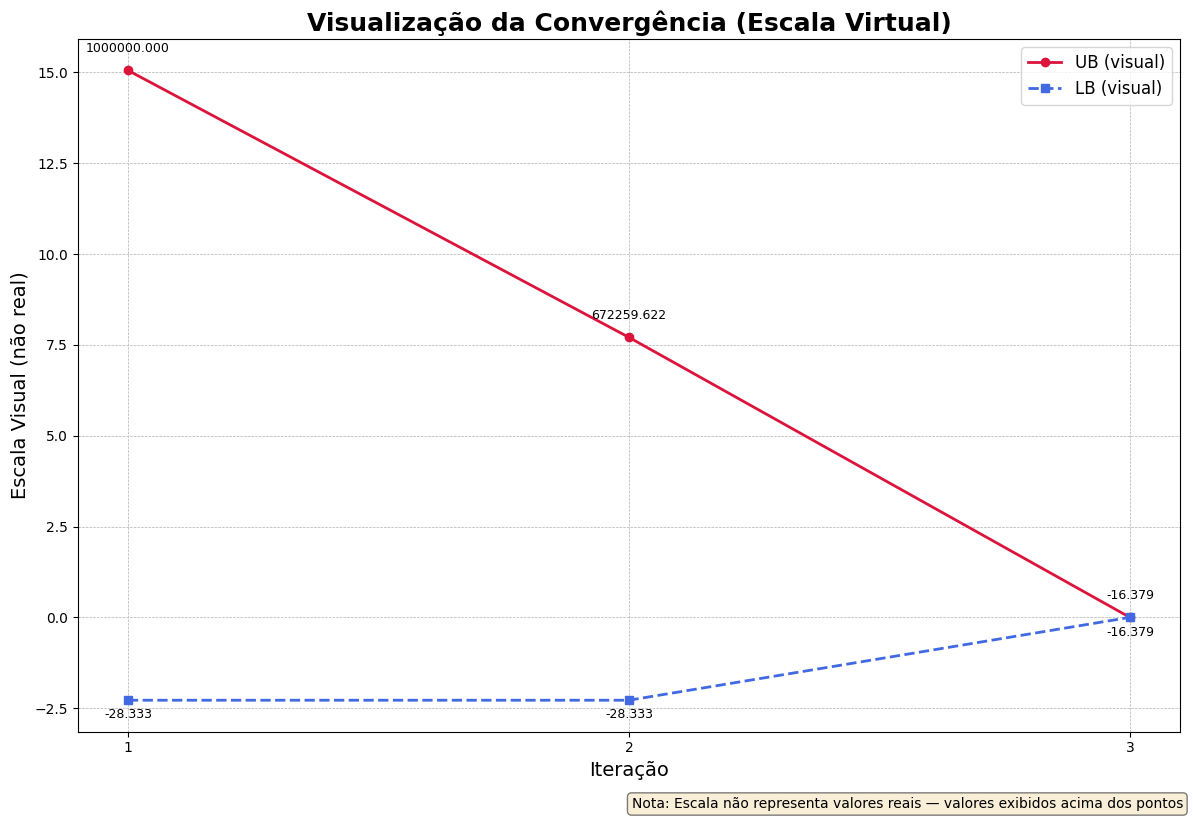

In [237]:
dw_solver.plot_convergence()

### Análise dos Resultados
---
#### 1. Resultado da Otimização
O algoritmo de Decomposição de Dantzig-Wolfe foi aplicado a um problema denso, sem estrutura de blocos evidente, e obteve sucesso na resolução.

- **Ótimo Esperado:** ```x = [3.8276, 2.7586]```, com ```Z ≈ -16.3793```

- **Ótimo Atingido pelo Código:** ```x = [3.8276, 2.7586]```, com ```Z = -16.379310```

A solução encontrada pelo código é idêntica à solução ótima esperada, tanto nos valores das variáveis de decisão quanto no valor da função objetivo. Isso valida a capacidade do algoritmo de resolver o problema corretamente.

#### 2. Análise da Convergência
O histórico dos limitantes demonstra um comportamento de convergência robusto e rápido.

- **Limitantes:** ```UB: [1e6, 672259.6, -16.379]```, ```LB: [-28.333, -28.333, -16.379]```

- **Iterações para Convergência:** ```3```

O comportamento dos limitantes foi ideal. O Limitante Superior (UB) apresentou o valor inicial alto esperado devido ao "Big M", caindo drasticamente para o valor ótimo na terceira iteração. O Limitante Inferior (LB) se manteve estável e monotonicamente não-decrescente, fornecendo uma garantia válida até encontrar o UB.

#### 3. Conclusão
O algoritmo funcionou perfeitamente para este caso, convergindo de forma eficiente em apenas 3 iterações. A união dos limitantes no valor ```-16.379``` fornece a prova matemática de que a solução encontrada é o ótimo global, demonstrando a eficácia do método mesmo para problemas sem uma estrutura de blocos natural.